In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
from matplotlib import gridspec
import re

import time
import pickle

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [2]:
mpl.__version__

'3.6.2'

In [3]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [4]:
%load_ext autoreload
%autoreload 2

from pubmed_landscape_src.plotting import *

In [5]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [6]:
plt.style.use("../matplotlib_style.txt")

# Fig S3: 

### Import

In [7]:
# import clean_df_updated
clean_df_updated_reparsed_filtered_with_authors_ISSN = pd.read_pickle(
    berenslab_data_path
    / "clean_df_updated_reparsed_filtered_with_authors_ISSN"
)

tcmalloc: large alloc 1073741824 bytes == 0x8b68fa000 @ 
tcmalloc: large alloc 1233903616 bytes == 0x9608b0000 @ 
tcmalloc: large alloc 2147483648 bytes == 0x9aa96e000 @ 
tcmalloc: large alloc 1542381568 bytes == 0x8f6a30000 @ 
tcmalloc: large alloc 1927979008 bytes == 0xa2a96e000 @ 


In [8]:
all_abstracts = (
    clean_df_updated_reparsed_filtered_with_authors_ISSN.AbstractText.to_list()
)

In [9]:
tsne_reparsed = np.load(variables_path / "tsne_reparsed.npy")

In [10]:
tsne_bert = np.vstack((-tsne_reparsed[:, 0], tsne_reparsed[:, 1])).T

### Calculation

In [14]:
def extract_n_samples(test_list):
    n_samples = [
        int(re.search("n\s?=\s?(\d+)", elem)[1])
        if re.search("n\s?=\s?(\d+)", elem) is not None
        else 0
        for elem in test_list
    ]
    n_samples = np.array(n_samples)
    return n_samples

In [15]:
%%time
n_samples = extract_n_samples(all_abstracts)

CPU times: user 1min 16s, sys: 9.59 s, total: 1min 26s
Wall time: 1min 26s


In [16]:
# Neuroscience colors

# Buscar
titles = clean_df_updated_reparsed_filtered_with_authors_ISSN["AbstractText"]
sub1 = " p="
sub2 = " p ="
sub3 = " p<"
sub4 = " p <"

indexes1 = titles.str.find(sub1)
indexes2 = titles.str.find(sub2)
indexes3 = titles.str.find(sub3)
indexes4 = titles.str.find(sub4)

mask_p = (
    (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1) | (indexes4 != -1)
)

# information
non_1_1 = indexes1[indexes1 != -1]
print("Number of titles with word 1: ", len(non_1_1))
non_1_2 = indexes2[indexes2 != -1]
print("Number of titles with word 2: ", len(non_1_2))
non_1_3 = indexes2[indexes3 != -1]
print("Number of titles with word 3: ", len(non_1_3))
non_1_4 = indexes2[indexes4 != -1]
print("Number of titles with word 4: ", len(non_1_4))

nsc_titles_word = titles[
    (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1) | (indexes4 != -1)
]
print("Number of titles with word: ", len(nsc_titles_word))

Number of titles with word 1:  100545
Number of titles with word 2:  185149
Number of titles with word 3:  96869
Number of titles with word 4:  177468
Number of titles with word:  467858


### Plot

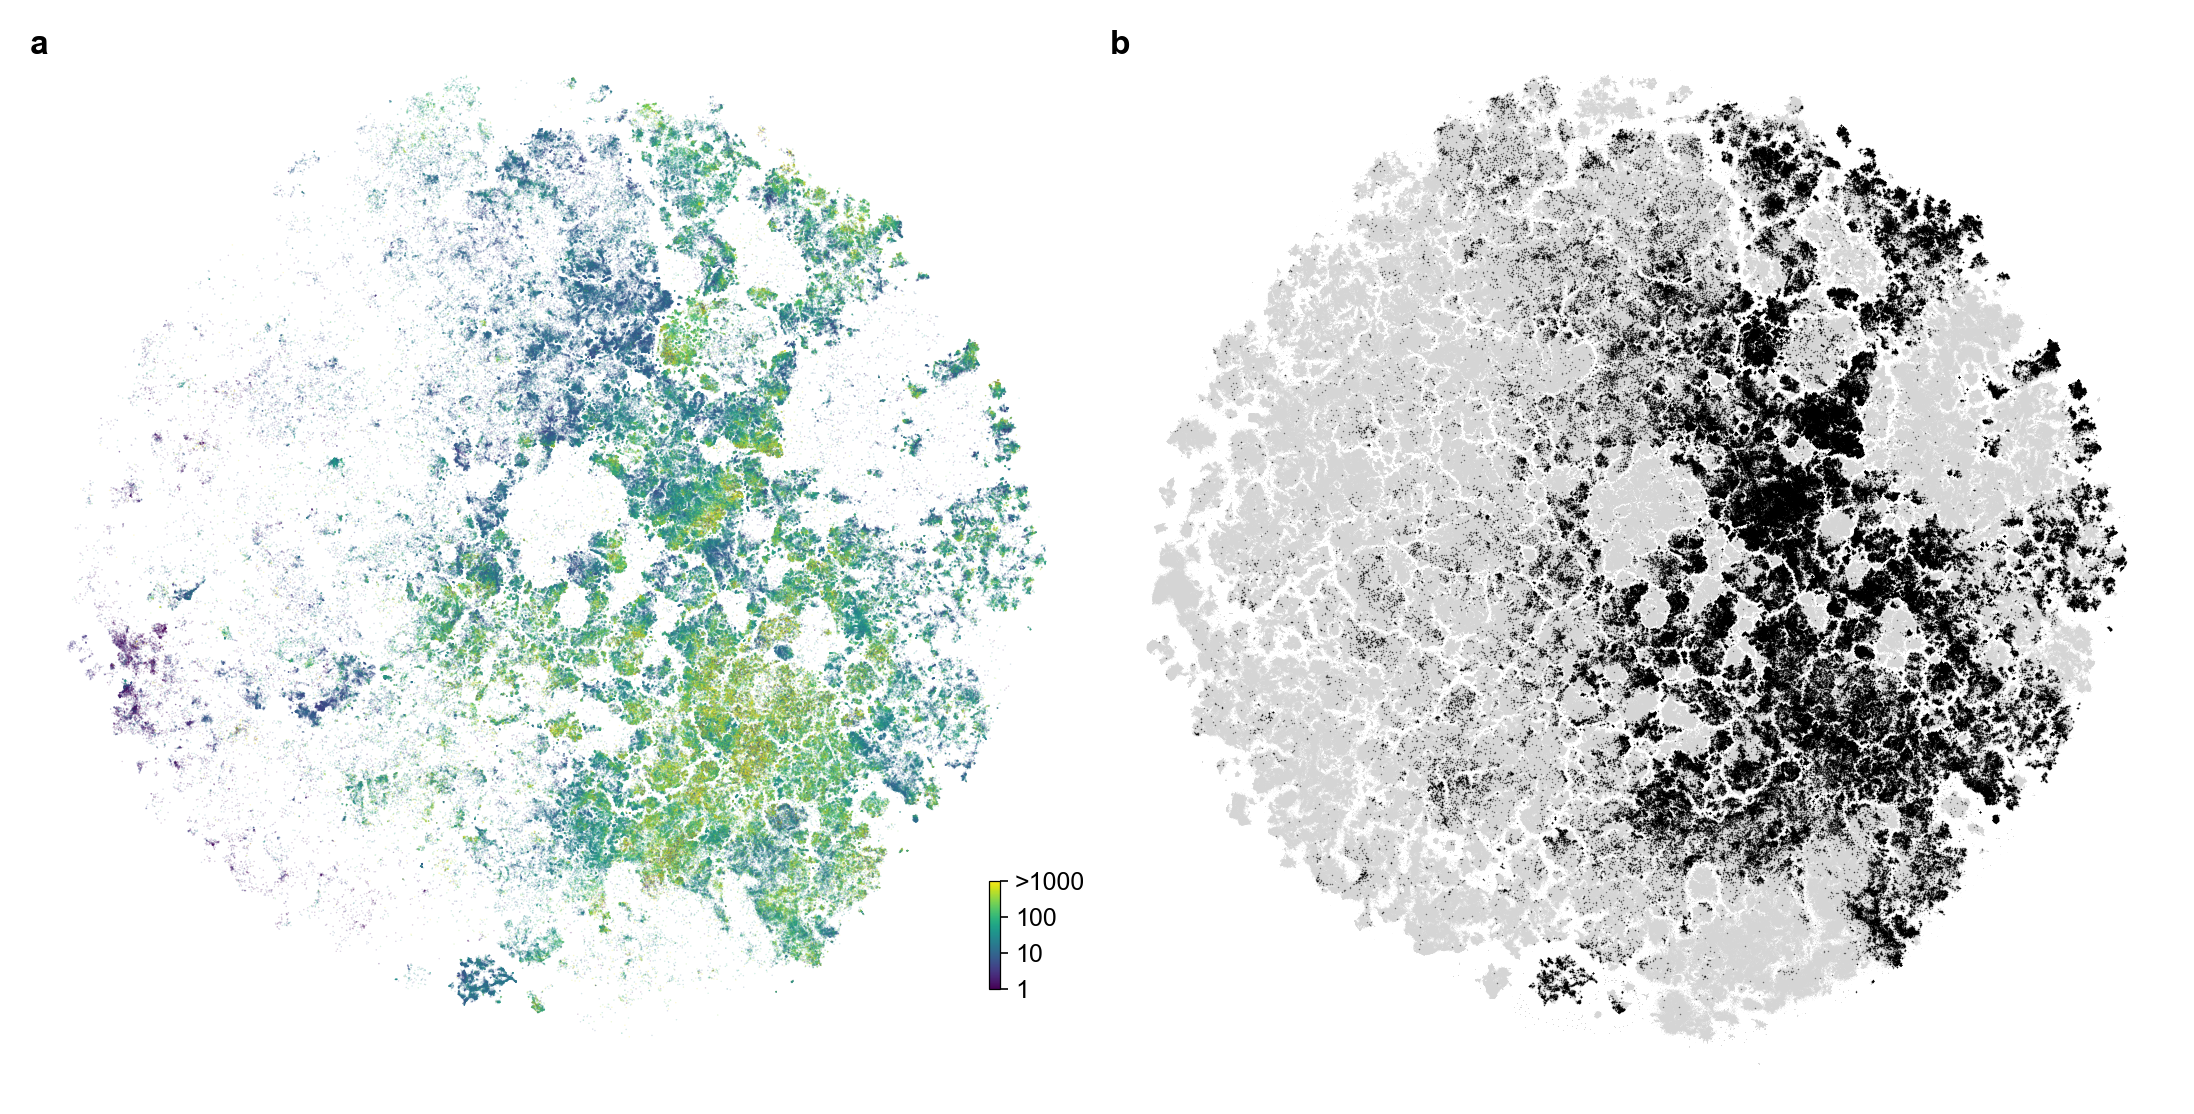

In [17]:
%matplotlib inline

fig, ax = plt.subplots(
    1, 2, figsize=(7.2, 3.6), dpi=300, sharey=True, layout="constrained"
)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

x_lim = (-240, 240)
y_lim = (-240, 240)
tsne = tsne_bert

# subplot a
reorder = np.random.permutation(tsne.shape[0])  # [:100]
ax[0].scatter(
    *tsne[reorder].T,
    s=0.5,
    c=n_samples[reorder],
    cmap="viridis",
    alpha=0.2,
    marker=".",
    linewidths=None,
    ec="None",
    rasterized=True,
    norm=matplotlib.colors.LogNorm(vmax=1000)
)

heatmap = ax[0].scatter([], [], c=[], cmap="viridis")
cax0 = fig.add_axes([0.45, 0.1, 0.005, 0.1])
cbar0 = fig.colorbar(heatmap, cax=cax0, shrink=0.1)
cbar0.set_alpha(1)
cbar0.ax.get_yaxis().set_ticks(np.linspace(0, 1, 4))
cbar0.ax.get_yaxis().set_ticklabels([1, 10, 100, ">1000"])
cbar0.ax.tick_params(labelsize=6)

ax[0].axis("scaled")  # ('equal')
ax[0].set_xlim(x_lim[0], x_lim[1])
ax[0].set_ylim(y_lim[0], y_lim[1])
ax[0].axis("off")
ax[0].text(
    0, 1, string.ascii_lowercase[0], transform=ax[0].transAxes, **txtkwargs
)


# subplot b
s_grey = 0.1
s_color = 0.5
alpha_grey = 0.2
alpha_color = 0.5

subregion = tsne[mask_p]
ax[1].scatter(
    tsne[:, 0],
    tsne[:, 1],
    c="lightgrey",
    s=s_grey,
    alpha=alpha_grey,
    linewidths=0,
    rasterized=True,
)
ax[1].scatter(
    subregion[:, 0],
    subregion[:, 1],
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)
# ax[1].set_title("p = ")
ax[1].axis("equal")
ax[1].set_xlim(x_lim[0], x_lim[1])
ax[1].set_ylim(y_lim[0], y_lim[1])
ax[1].axis("off")
ax[1].text(
    0, 1, string.ascii_lowercase[1], transform=ax[1].transAxes, **txtkwargs
)


fig.savefig(figures_path / "fig_S3_bert_colored_by_p_n.png", dpi=300)
fig.savefig(figures_path / "fig_S3_bert_colored_by_p_n.pdf", dpi=300)